In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
sns.set_theme(style='white', context='notebook', font_scale=1.33)

## Section 1: Demographics

TO-DO: once reviewed, make sure tables presented here match paper

#### 1.1 Load and prepare data

In [2]:
## Load and prepare data.
metadata = read_csv(os.path.join('data', 'metadata.tsv'), sep='\t')

## Format data.
metadata = metadata.rename(columns={'gender-categorical':'gender'})
metadata = metadata.replace({'Associate degree':'Some college',
                             'Less than high school':'High school'})

## Apply rejections.
reject = read_csv(os.path.join('data', 'reject.csv'))
metadata = metadata.loc[metadata.subject.isin(reject.query('reject==0').subject)]

#### 4.2 Gender / age composition

                count  mean   std   min   25%   50%   75%   max
gender                                                         
Female          811.0  27.7   9.6  18.0  21.0  24.0  32.0  74.0
Male            670.0  30.1  10.1  18.0  22.0  28.0  36.0  70.0
Other            13.0  26.3   4.8  19.0  23.0  27.0  30.0  35.0
Rather not say    2.0  22.0   2.8  20.0  21.0  22.0  23.0  24.0


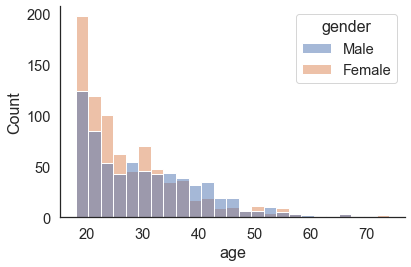

In [3]:
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(6,4))

## Print gender / age composition.
print(metadata.groupby('gender').age.describe().round(1))

## Plot gender / age composition.
sns.histplot(x='age', hue='gender', data=metadata, hue_order=['Male','Female'], ax=ax)

sns.despine()
plt.tight_layout()

In [4]:
metadata.age.describe()

count    1496.000000
mean       28.747995
std         9.853712
min        18.000000
25%        21.000000
50%        26.000000
75%        34.000000
max        74.000000
Name: age, dtype: float64

#### 4.3 Education

education,Bachelor degree,High school,Master degree or higher,Rather not say,Some college
gender,,,,,
Female,310,109,115,2,275
Male,192,89,207,0,187
Other,5,0,0,0,8
Rather not say,0,1,0,0,1


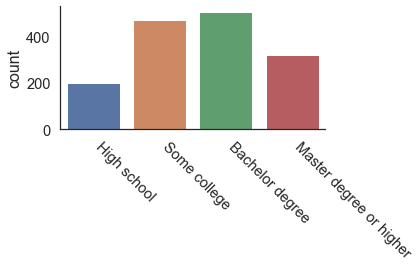

In [5]:
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(6,4))
order = ['High school', 'Some college', 'Bachelor degree', 'Master degree or higher']

## Plot gender / age composition.
sns.countplot(x='education', data=metadata, order=order, ax=ax)

## Add detail.
ax.set(xlabel='')
ax.set_xticklabels(order, rotation=-45, ha='left')

sns.despine()
plt.tight_layout()

metadata.pivot_table('subject','gender','education',aggfunc='count').fillna(0).astype(int)

In [6]:
metadata.education.value_counts()

Bachelor degree            507
Some college               471
Master degree or higher    322
High school                199
Rather not say               2
Name: education, dtype: int64

## Section 1: Summarize data

#### 1.1 Load and prepare data

In [7]:
## Load and prepare data.
data = read_csv(os.path.join('data', 'data.csv'))

## Apply rejections.
reject = read_csv(os.path.join('data', 'reject.csv'))
data = data.loc[data.subject.isin(reject.query('reject==0').subject)]

## Handle incomplete responses.
data['missing'] = data.accuracy.isnull().astype(int)
data['accuracy'] = data.accuracy.fillna(0)

#### 1.2 Summarize data

In [8]:
## Summarize dataset.
print('Summary')
print('N trial = %s' %data.shape[0])
print('N subj  = %s' %data.subject.nunique())
print('N item  = %s' %data.item.nunique())

## Quality metrics.
print('\nQuality')
print('Missing: %0.2f%%' %(data.missing.mean() * 100))
print('Rapid:   %0.2f%%' %((data.rt < 3).mean() * 100))

Summary
N trial = 24016
N subj  = 1501
N item  = 64

Quality
Missing: 1.75%
Rapid:   1.08%


## Section 2: Item Sampling

TO-DO: once reviewed, make sure tables presented here match paper

#### 2.1 Available data by item

In [9]:
data.item.value_counts().describe()

count     64.000000
mean     375.250000
std       12.014541
min      348.000000
25%      366.750000
50%      374.500000
75%      383.000000
max      403.000000
Name: item, dtype: float64

In [10]:
data.item_id.value_counts().describe()

count    384.000000
mean      62.541667
std        6.904294
min       47.000000
25%       58.000000
50%       63.000000
75%       67.000000
max       86.000000
Name: item_id, dtype: float64

## Section 3: Behavior

#### 3.1 Participant accuracy

In [11]:
gb = data.groupby('subject').accuracy.sum()
gb.describe().round(1)

count    1501.0
mean        9.6
std         3.1
min         1.0
25%         8.0
50%        10.0
75%        12.0
max        16.0
Name: accuracy, dtype: float64

In [12]:
(gb < 4).sum()
(gb < 4).mean() * 100

2.8647568287808127

In [13]:
(gb == 16).sum()
(gb == 16).mean() * 100

0.7328447701532311

#### 3.2 Item accuracy

In [14]:
gb = data.groupby('item_id').accuracy.mean()
gb.describe().round(2)

count    384.00
mean       0.60
std        0.19
min        0.09
25%        0.45
50%        0.59
75%        0.74
max        1.00
Name: accuracy, dtype: float64

In [15]:
(gb < 0.25).sum() 
(gb < 0.25).mean() * 100

3.125

In [16]:
(gb > 0.9).sum() 
(gb > 0.9).mean() * 100

5.729166666666666

#### 3.2 Accuracy by dimension

In [17]:
from scipy.stats import spearmanr

gb = data.groupby('item_id').agg({'dimension':'mean', 'accuracy':'mean'})

spearmanr(gb.dimension, gb.accuracy)

SpearmanrResult(correlation=-0.4821668919802551, pvalue=9.448691947102312e-24)

#### Consistency

In [18]:
from scipy.stats import spearmanr

## Load and prepare original data summary.
stats = read_csv(os.path.join('data','stats.csv'))
stats = stats.query('Group=="total" and N >= 200')
stats = stats[['Item','Mean.correct']].rename(columns={'Item':'item','Mean.correct':'correct'})

## Compute accuracy by item.
gb = data.groupby('item').accuracy.mean().reset_index()
gb = gb.merge(stats, on='item')

## Compute consistency.
spearmanr(gb.correct, gb.accuracy)

SpearmanrResult(correlation=0.8704527612028681, pvalue=1.554252090281414e-08)

## Section 4: Response times

In [19]:
data.rt.describe()

count    23596.000000
mean        15.917140
std          7.240629
min          0.187000
25%         10.144500
50%         14.966500
75%         21.470500
max         29.997000
Name: rt, dtype: float64

In [20]:
from statsmodels.api import MixedLM

zscore = lambda x: (x - np.nanmean(x)) / np.nanstd(x)
data['difficulty'] = zscore(1 - data.groupby('item_id').accuracy.transform(np.mean))
data['score'] = zscore(data.groupby('subject').accuracy.transform(np.sum) - data.accuracy)
data['logrt'] = np.log(data.rt)

formula = 'logrt ~ accuracy * difficulty * score'
fit = MixedLM.from_formula(formula, data=data.dropna(), groups=data.dropna().subject).fit()
fit.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
=====================================================================
Model:                MixedLM     Dependent Variable:     logrt      
No. Observations:     23596       Method:                 REML       
No. Groups:           1501        Scale:                  0.1783     
Min. group size:      13          Log-Likelihood:         -14702.1112
Max. group size:      16          Converged:              Yes        
Mean group size:      15.7                                           
---------------------------------------------------------------------
                          Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  2.648    0.009 287.757 0.000  2.630  2.666
accuracy                   0.039    0.007   5.367 0.000  0.025  0.053
difficulty                 0.073    0.005  13.292 0.000  0.062  0.083
accuracy:difficulty        0.097    0.007  14.351 0.000  0.084  0.110
score                      0.167    0.009  19.204 0.000  0.150  0.184
accuracy:score            -0.064    0.007  -8.764 0.000 -0.078 -0.050
difficulty:score           0.032    0.005   6.549 0.000  0.023  0.042
accuracy:difficulty:score  0.012    0.006   1.955 0.051 -0.000  0.025
Group Var                  0.077    0.008                            
=====================================================================

"""

## Figures

In [ ]:
import matplotlib.gridspec as gridspec
sns.set_theme('notebook', style='white', font='sans-serif', font_scale=1.33)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig = plt.figure(figsize=(12,6))

## Initialize panels.
spec = fig.add_gridspec(3, 2, left=0.08, right=0.98, top=0.98, bottom=0.12, wspace=0.08, hspace=0.0)

## Palette.
color = '#4c72b0' #'#AA3939'

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Panel 1: Item distributions.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

gb = data.groupby('item_id').agg({'accuracy':'mean', 'rt':'median'})

## Initialize axis.
ax = plt.subplot(spec[0,0])
sns.histplot(x='accuracy', data=gb, bins=np.linspace(0,1,11), color=color, ax=ax)
ax.set(xlim=(-0.02,1.02), xticks=[], xlabel='', yticks=[], ylabel='')
sns.despine(ax=ax, left=True, bottom=True)
ax.annotate('A', (0,0), (0.0,0.8), xycoords='axes fraction', ha='left', va='bottom', 
            fontsize=28, fontweight='bold')

## Initialize axis.
ax = plt.subplot(spec[1:,0])
ax.set_xlim(-0.02,1.02)

sns.scatterplot(x='accuracy', y='rt', data=gb, s=35, color=color, zorder=-1, ax=ax)
sns.regplot(x='accuracy', y='rt', data=gb, scatter=False, truncate=False, color='k', ax=ax)
ax.set(xlabel='Proportion correct', ylim=(0,31), ylabel='Median response time (s)')

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Panel 2: Participant distributions.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

gb = data.groupby('subject').agg({'accuracy':'sum', 'rt':'median'})

## Initialize axis.
ax = plt.subplot(spec[0,1])
sns.histplot(x='accuracy', data=gb, bins=np.arange(18)-0.5, color=color, ax=ax)
ax.set(xlim=(-0.5,16.5), yticks=[], ylabel='')
sns.despine(ax=ax, left=True, bottom=True)
ax.annotate('B', (0,0), (0.0,0.8), xycoords='axes fraction', ha='left', va='bottom', 
            fontsize=28, fontweight='bold')

## Initialize axis.
ax = plt.subplot(spec[1:,1])
ax.set_xlim(-0.5,16.5) 

sns.stripplot(x='accuracy', y='rt', order=np.arange(17), data=gb, size=3.2, jitter=0.2, 
              color=color, zorder=-1, ax=ax)
sns.regplot(x='accuracy', y='rt', data=gb, scatter=False, truncate=False, color='k', ax=ax)
ax.set(xticks=np.arange(0,17,2), xlabel='Observed scores', ylim=(0,31), yticks=[], ylabel='')

plt.savefig(os.path.join('..', '05_Figures', 'fig01.png'), dpi=100)

In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(1,3,figsize=(12,4),constrained_layout=True)

## Define styling.
sns.set_theme('notebook', style='white', font='sans-serif', font_scale=1.33)

## Define aesthetics.
xytext = (0, 1.05)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Panel 2: Participant scores.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute participant observed scores.
gb = data.groupby('subject').accuracy.sum()

## Plot item accuracy.
sns.histplot(x=gb, bins=np.arange(18)-0.5, ax=axes[0])

## Add details.
axes[0].set(xlim=(-0.5,16.5), xticks=np.arange(0,17,2), xlabel='Observed scores', 
            yticks=np.arange(0,201,50), ylabel='Number of participants')
axes[0].annotate('A', (0,0), xytext, xycoords='axes fraction', ha='right', va='bottom', 
                 fontsize=28, fontweight='bold')

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Panel 2: Item accuracy.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute item accuracy rates.
gb = data.groupby('item_id').accuracy.mean()

## Plot item accuracy.
sns.histplot(x=gb, bins=np.linspace(0,1,11), ax=axes[1])

## Add details.
axes[1].set(xlim=(0,1), xticks=np.arange(0,1.1,0.2), xlabel='Proportion correct', 
            yticks=np.arange(0,100,20), ylabel='Number of items')
axes[1].annotate('B', (0,0), xytext, xycoords='axes fraction', ha='right', va='bottom', 
                 fontsize=28, fontweight='bold')

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Panel 3: Response times.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Divide items into quintiles by difficulty.
data['difficulty'] = 1 - data.groupby('item_id').accuracy.transform(np.mean)
data['difficulty'] = np.digitize(data.difficulty, data.difficulty.quantile([0.2,0.4,0.6,0.8]))

## Divide participants into quartiles by observed score.
data['score'] = data.groupby('subject').accuracy.transform(np.sum)
data['score'] = np.digitize(data.score, [4.5,8.5,12.5])

## Plot response times.
palette = sns.color_palette('Blues_r', n_colors=8).as_hex()[:data.difficulty.nunique()]
sns.pointplot(x='score', y='rt', hue='difficulty', data=data, hue_order=[4,3,2,1,0],
              estimator=np.median, palette=palette, ax=axes[2])

## Add details.
axes[2].set(xlabel='Observed scores', xticklabels=['1 - 4', '5 - 8', '9 - 12', '13 - 16'],
            yticks=np.arange(10,26,5), ylabel='Median response time (s)')
axes[2].annotate('C', (0,0), xytext, xycoords='axes fraction', ha='right', va='bottom', 
                 fontsize=28, fontweight='bold')
axes[2].legend(loc=7, bbox_to_anchor=(1.20, 0.5), frameon=False, handletextpad=0)

sns.despine()
plt.savefig(os.path.join('..', '05_Figures', 'fig01.png'), dpi=100)